# **Multi Task Learning**

In this notebook we will learn how to use Multi-Task Learning to train a model to simultaneously segment and predict depth on a single image

### References:
- https://arxiv.org/pdf/1705.07115.pdf
- https://arxiv.org/pdf/1706.05587.pdf
- https://cs.nyu.edu/~silberman/papers/indoor_seg_support.pdf

In [32]:
import os

import numpy as np
import h5py
import cv2

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from nyu_dataset import NyuDataset
from utils import *

%matplotlib inline

## CONFIGs

In [2]:
BATCH_SIZE = 16
EPOCHS = 100
LR = 1e-4

## Get Train/Valid/Test split

Since we are accessing the .mat file as an h5 object, we will make 2 datasets one for training and the other for valid/test/inference. If we set the random seed, this will allow us to get the appropriate splits.

In [3]:
root = r"C:\Users\itber\Documents\datasets\nyu_depth_seg\nyu_depth_v2_labeled.mat"

In [4]:
train_augmentations = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop((240, 320)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1, 1)),
    transforms.ElasticTransform(alpha=25.0, sigma=5.0),
])

test_augmentations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((240, 320)),
])

train_nyu_dataset = NyuDataset(root, augmentations=train_augmentations, normalize=True, depth_norm=10)
test_nyu_dataset = NyuDataset(root, augmentations=test_augmentations, normalize=True, depth_norm=10)

In [5]:
from torch.utils.data import random_split

seed = 42

# get train split
num_train = round(0.7*len(train_nyu_dataset))
num_remain = round(0.3*len(train_nyu_dataset))
(train_dataset, _) = random_split(train_nyu_dataset,
                                              [num_train, num_remain],
                                              generator=torch.Generator().manual_seed(seed))

""" 
Sketchy hack to get valid/test datasets
"""

(_, remain_dataset) = random_split(test_nyu_dataset,
                                              [num_train, num_remain],
                                              generator=torch.Generator().manual_seed(seed))

# get valid and test split
num_valid = round(0.8*len(remain_dataset))
num_test = round(0.2*len(remain_dataset))
(valid_dataset, test_dataset) = random_split(remain_dataset,
                                             [num_valid, num_test],
                                              generator=torch.Generator().manual_seed(seed))

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) 
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [7]:
image, (depth, label) = next(iter(train_dataloader))

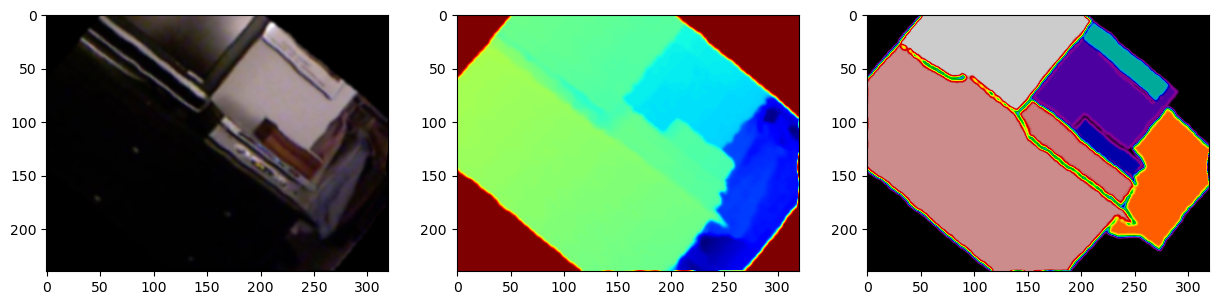

In [8]:
# get format for display
idx = 10
image_np, depth_np, label_np = convert_to_numpy(image[idx], depth[idx], label[idx])

_, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(image_np)
ax[1].imshow(depth_np, cmap='jet_r')
ax[2].imshow(label_np, cmap='nipy_spectral');

## Get the model

Look at this [resource](https://discuss.pytorch.org/t/how-can-i-replace-the-forward-method-of-a-predefined-torchvision-model-with-my-customized-forward-function/54224/7) to learn how to make a custom forward function for the backbone

In [26]:
from torchvision.models import resnet18
from torchvision.models.inception import inception_v3
from torchvision.models.segmentation import deeplabv3_resnet50


# get backbone and download pretrained weights
backbone = resnet18(weights='IMAGENET1K_V1')
# backbone = inception_v3(weights='IMAGENET1K_V1')
encoder = deeplabv3_resnet50(weights='COCO_WITH_VOC_LABELS_V1', weights_backbone='IMAGENET1K_V1')

In [31]:
nn.ModuleList(backbone.children())[:-2]

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [22]:
from copy import deepcopy
head = deepcopy(encoder.classifier)

encoder.classifier = nn.Identity()
encoder.aux_classifier = nn.Identity()

backbone.avgpool = nn.Identity()
backbone.dropout = nn.Identity()
backbone.fc = nn.Identity()

In [23]:
# encoder
backbone

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [18]:
backbone.layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [19]:
encoder

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [13]:
class MultiTaskModel(nn.Module):
    def __init__(self, backbone):
        super(MultiTaskModel, self).__init__()
        self.backbone = backbone
        self.n_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.backbone.avgpool = nn.Identity()

        # # Age Regression
        # self.net.fc1 = nn.Sequential(OrderedDict([
        #     ('linear', nn.Linear(self.n_features,self.n_features)),
        #     ('relu1', nn.ReLU()),
        #     ('final', nn.Linear(self.n_features, 1))
        #     ]))
        
        # # Gender Classification
        # self.net.fc2 = nn.Sequential(OrderedDict([
        #     ('linear', nn.Linear(self.n_features,self.n_features)),
        #     ('relu1', nn.ReLU()),
        #     ('final', nn.Linear(self.n_features, 1))
        #     ]))
        
        # # Race Classification
        # self.net.fc3 = nn.Sequential(OrderedDict([
        #     ('linear', nn.Linear(self.n_features,self.n_features)),
        #     ('relu1', nn.ReLU()),
        #     ('final', nn.Linear(self.n_features, 5))
        #     ]))
        
    def forward(self, x):
        x = self.backbone(x)

        return x

In [126]:
model = MultiTaskModel(backbone)

In [24]:
backbone.to('cuda')
backbone.eval()
outputs = backbone(image.to('cuda'))

In [25]:
outputs.shape

torch.Size([16, 98304])

In [ ]:
outputs

In [11]:
encoder.to('cuda')
encoder.backbone.eval()
outputs = encoder.backbone(image.to('cuda'))

In [12]:
outputs.keys()

odict_keys(['aux', 'out'])

In [13]:
outputs['out'].shape

torch.Size([16, 2048, 30, 40])

In [14]:
outputs['aux'].shape

torch.Size([16, 1024, 30, 40])

In [15]:
image.shape

torch.Size([16, 3, 240, 320])

In [16]:
head.to('cuda')
head_out = head(outputs['out'].to('cuda'))

In [17]:
head_out.shape

torch.Size([16, 21, 30, 40])

In [33]:
from torchvision.models.resnet import ResNet, BasicBlock

class MyResNet18(ResNet):
    def __init__(self):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])
        
    def forward(self, x):
        # change forward here
        x = self.conv1(x)
        return x


model = MyResNet18()
# if you need pretrained weights
model.load_state_dict(torchvision.models.resnet18(pretrained=True).state_dict())

c:\Users\itber\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\itber\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [34]:
model

MyResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [35]:
model.to('cuda')
outs = model(image.to('cuda'))

In [37]:
outs.shape

torch.Size([16, 64, 120, 160])